In [1]:
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [2]:
from predict_next_token_in_time_series import *

# Generate data

/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/predict_next_token_in_time_series.py:44: RuntimeWarning: invalid value encountered in sqrt
  return self.delta_sigma * np.sqrt(np.pi * a) * self.beta
/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/predict_next_token_in_time_series.py:48: RuntimeWarning: overflow encountered in power
  return self.C * (self.delta_K(a) ** self.m)


(np.float64(4.75408478175169e-06), np.float64(2.7136972403102657), (950, 100))

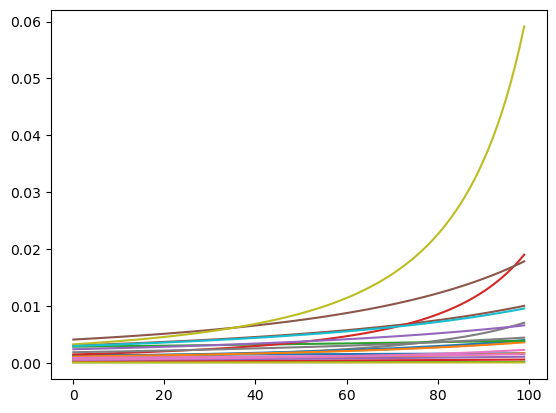

In [3]:
length = 100
n0 = 50
paris_episodes = np.empty((0, length))
for C in [1e-8, 3e-8, 5e-8, 7e-8, 8e-8]:
    for l0 in [0.0045, 0.003, 0.0015, 0.0007, 0.0001]:
        paris = ParisLawDegradation(length=length, dim=1, C=C)
        episodes_i = paris.generate_episode(x0=np.random.randn(n0)*0.0003+l0)  # Initial crack lengths in meters
        paris_episodes = np.concatenate([paris_episodes, episodes_i], axis=0)

#drop invalid values
paris_episodes = paris_episodes[~np.isnan(paris_episodes).any(axis=1)]
paris_episodes = paris_episodes[(paris_episodes<3).all(axis=1)]
paris_episodes = paris_episodes[(paris_episodes>=0).all(axis=1)]

paris_episodes.shape
# plot 20 random episodes
plt.plot(paris_episodes[np.random.randint(0, paris_episodes.shape[0], size=20)].T)
paris_episodes.min(), paris_episodes.max(), paris_episodes.shape

(np.float64(9.221469794491578e-05), np.float64(2.997985461187601), (544, 100))

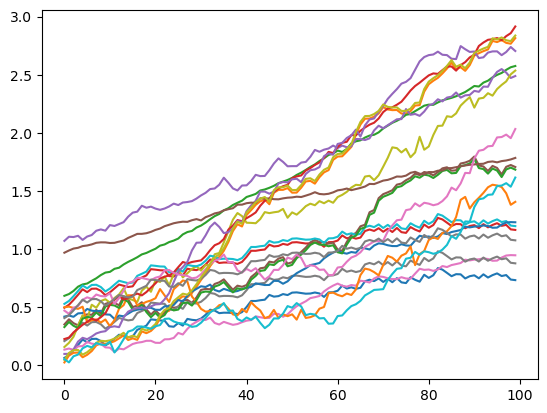

In [4]:
lin_episodes = np.empty((0, length))
for c in np.linspace(0.01, 0.05, 5):
    for sigma_e in np.linspace(0.01, 0.05, 5):
        lin = LinearDegradation(length=length, dim=1, c=c, mu_e=0, sigma_e=sigma_e)
        episodes_i = lin.generate_episode(x0=np.abs(np.random.randn(n0)*0.5))  # Initial crack lengths in meters
        lin_episodes = np.concatenate([lin_episodes, episodes_i], axis=0)

#drop invalid values
lin_episodes = lin_episodes[~np.isnan(lin_episodes).any(axis=1)]
lin_episodes = lin_episodes[(lin_episodes<3).all(axis=1)]
lin_episodes = lin_episodes[(lin_episodes>=0).all(axis=1)]

lin_episodes.shape
# plot 20 random episodes
plt.plot(lin_episodes[np.random.randint(0, lin_episodes.shape[0], size=20)].T)
lin_episodes.min(), lin_episodes.max(), lin_episodes.shape

(np.float64(0.0018881638163585949), np.float64(2.9941351548972754), (245, 100))

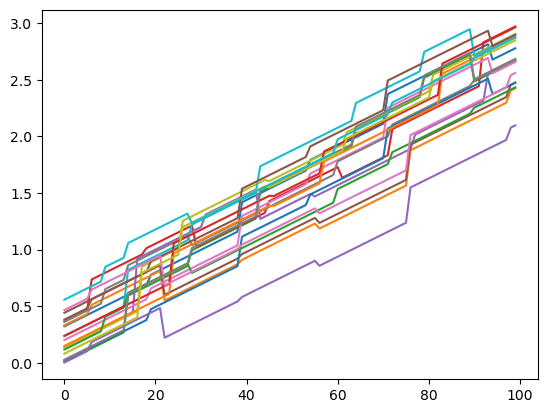

In [5]:
shock_episodes = np.empty((0, length))
for sigma_t in np.linspace(2, 7, 5):
    for sigma_shock in np.linspace(0.1, 0.3, 5):
        shock = RandomShockDegradation(length=length, dim=1, mu_t=15, sigma_t=sigma_t, mu_shock=0.2, sigma_shock=sigma_shock, baseline=True)
        
        episodes_i = shock.generate_episode(x0=np.abs(np.random.randn(n0)*0.5))  # Initial crack lengths in meters
        shock_episodes = np.concatenate([shock_episodes, episodes_i], axis=0)

#drop invalid values
shock_episodes = shock_episodes[~np.isnan(shock_episodes).any(axis=1)]
shock_episodes = shock_episodes[(shock_episodes<3).all(axis=1)]
shock_episodes = shock_episodes[(shock_episodes>=0).all(axis=1)]

shock_episodes.shape
# plot 20 random episodes
plt.plot(shock_episodes[np.random.randint(0, shock_episodes.shape[0], size=20)].T)
shock_episodes.min(), shock_episodes.max(), shock_episodes.shape

In [6]:
episodes = np.concatenate([lin_episodes, shock_episodes, paris_episodes], axis=0)

In [7]:

# Check default device
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
#device = torch.device('cpu')  # Force CPU for consistency in this example
print("Default Device:", device)

Default Device: mps


In [8]:
print(f"Min: {episodes.min()}")
print(f"Max: {episodes.max()}")

Min: 4.75408478175169e-06
Max: 2.997985461187601


# Set up model and training params

In [9]:
vocab_size=500
context_window=40
bs = 32
# Split episodes into train/test (e.g., 80/20)
n_train = int(0.8 * len(episodes))
train_episodes = episodes[:n_train]
test_episodes = episodes[n_train:]
train_dataset = TimeSeriesDataset(train_episodes, context_window=context_window, vocab_size=vocab_size)
test_dataset = TimeSeriesDataset(test_episodes, context_window=context_window, vocab_size=vocab_size)
len(train_dataset), len(test_dataset)

(83460, 20880)

In [10]:
train_episodes.shape, test_episodes.shape

((1391, 100), (348, 100))

In [11]:
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False, pin_memory=True, num_workers=2)
len(train_loader), len(test_loader)

(2609, 653)

In [12]:
model = DegradationTransformer(vocab_size=vocab_size, context_window=context_window, 
                               embedding_dim=128, num_heads=8, num_blocks=4)
optim = torch.optim.Adam(model.parameters(), lr=0.002)
loss_func = torch.nn.CrossEntropyLoss()
len(train_loader), len(test_loader)
cbs = [ProgressCallback(50)]
learner = Learner(model, optim, loss_func, train_loader, test_loader, cbs, device=device)
learner.fit(3)

KeyboardInterrupt: 

In [15]:
learner.predict(test_episodes[58:60,:40], num_periods=60).shape

(2, 100)

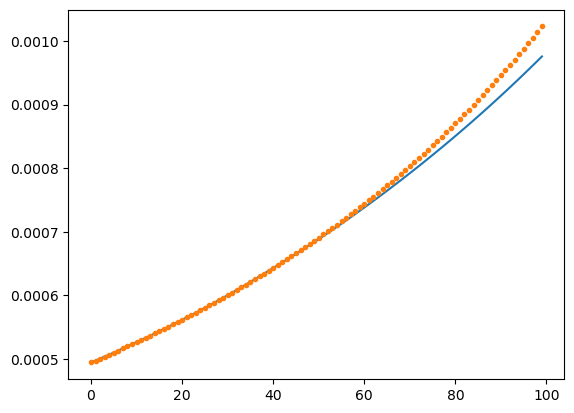

In [16]:

plt.plot(learner.predict(test_episodes[58,:40], num_periods=60).T)
plt.plot(test_episodes[58, ].T, '.')

